# **Group Project**

## **GRA 65602 - Strategic Asset Allocation**

This notebook contains the computations and models used to answer the questions

In [17]:
##
#  This cell cleans the environment
##
rm(list = ls())

In [18]:
##
#  This cell installs the packages for the libraries used
#  Uncomment if necessary
##
#install.packages(c("readxl", "ggplot2", "moments", "matlib", "zoo", "latex2exp", "MASS"))

In [19]:
##
#  This cell loads the libraries and modules needed
#  @library readxl to read excel files
#  @library moments to compute statistics
#  @library zoo to compute correlations in rolling windows
#  @library latex2exp for formatting text in Latex
#  @library showtext to find fonts for plotting
#  @library systemfonts finds fonts for plotting
#  @module portConstruct with various portfolio construction methods
#  @module portUtility with CRRA utility portfolio construction methods
##
library(readxl)
library(moments)
library(zoo)
library(latex2exp)
library(showtext)
library(systemfonts)
library(MASS)
source('portConstruct.R')
source("portUtility.R")

In [20]:
##
#  This cell sets Times New Roman as font for the plots
##
tnr_path <- systemfonts::match_fonts("Times New Roman")$path
font_add("Times New Roman", regular = tnr_path)
showtext_auto()
par(family = "Times New Roman")

In [21]:
##
#  This cell loads and transforms the main data set
#  @dataset data.xlsx file containing the data
#  @return dataset expressed in decimals and formated date 
##
set.seed(1) # reproductability of results when simulating
data                                      <- read_excel("data.xlsx", sheet = "csv")
data$Date                                 <- as.Date(data$Date, format = "%Y-%m-%d")
names(data)[names(data) == "Date"]        <- "date"
nonPercentage                             <- c("date", "P/D", "P/E")
idx                                       <- !(names(data) %in% nonPercentage)
data[idx]                                 <- lapply(data[idx], `/`, 100)          # deals with NAs
head(data)

date,us_eq,us_t1m,us_t1yr,us_t2yr,us_t5yr,us_t7yr,us_t10yr,us_t20yr,us_t30yr,⋯,wlrd_gbnd,wrldx_gbnd,dow_cbnd,com_ind,oil,us_infl,P/D,P/E,y_3m,y_10y
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1946-12-31,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,22.62941,11.37278,0.0038,0.0182
1947-01-31,0.013084,0.0002640758,0.0017831245,0.0015698055,0.0022676117,0.0029087267,0.0022745171,-0.0006277434,-0.0006277434,⋯,0.005332620,0.005390308,0.010792164,0.006595822,NA,0.006517691,22.76622,11.46930,0.0038,0.0178
1947-02-28,-0.011091,0.0002852513,0.0006268155,0.0002132673,0.0005898492,0.0021162524,0.0032339512,0.0021007895,0.0021007895,⋯,-0.003177945,-0.004867873,0.003757280,0.032140777,NA,0.017576318,21.79050,11.94957,0.0038,0.0176
1947-03-31,-0.016790,0.0002852513,0.0010524982,0.0021829849,0.0023983397,0.0031710272,0.0013810466,0.0019812779,0.0019812779,⋯,-0.002681048,-0.003775328,0.001185352,0.084377289,NA,0.000000000,21.19307,11.28790,0.0038,0.0176
1947-04-30,-0.047698,0.0002852187,0.0004539845,-0.0000135084,-0.0013039708,-0.0003692658,-0.0004302926,-0.0036749641,-0.0036749641,⋯,0.002685794,0.003484741,-0.005452393,-0.122415826,NA,-0.002272727,19.96608,10.90083,0.0038,0.0178
1947-05-31,-0.009625,0.0002852662,0.0012199022,0.0005606063,0.0007754507,0.0024416991,0.0021270669,0.0033415158,0.0033415158,⋯,0.002503421,0.002535754,-0.008990946,-0.053102516,NA,0.005922551,19.15370,10.73367,0.0038,0.0177


In [22]:
##
#  2.1 This cell gets the data used for the benchmark ptf
##
selectColumns           <- c("date", "us_t1m", "us_infl", "wrld_eq", "wlrd_gbnd")
data7030                <- data[-1, selectColumns]
colnames(data7030)      <- c("date", "rf", "inflation", "equity", "bonds")
head(data7030)

date,rf,inflation,equity,bonds
<date>,<dbl>,<dbl>,<dbl>,<dbl>
1947-01-31,0.0002640758,0.006517691,0.0283385093,0.005332620
1947-02-28,0.0002852513,0.017576318,-0.0003775009,-0.003177945
1947-03-31,0.0002852513,0.000000000,0.0147280967,-0.002681048
1947-04-30,0.0002852187,-0.002272727,0.0078154075,0.002685794
1947-05-31,0.0002852662,0.005922551,-0.0121861152,0.002503421
1947-06-30,0.0002851915,0.006793478,0.0093457944,-0.004443557


[1] "Correlation cor(r_equity,r_bonds) = 0.3356"

[1] "Covariance cov(r_equity,r_bonds) = 0.00026"

[1] "First (mean) and second (variance) moments:"

asset,equity,bonds
mean,0.0057,0.0020
sigma,0.0391,0.0200
sigma2,0.0015,0.0004
sharpeRatio,0.1460,0.0977


[1] "------------------------------------------------------------"

[1] "The inferred relative risk aversion (gamma) is 4.4406"

[1] "------------------------------------------------------------"

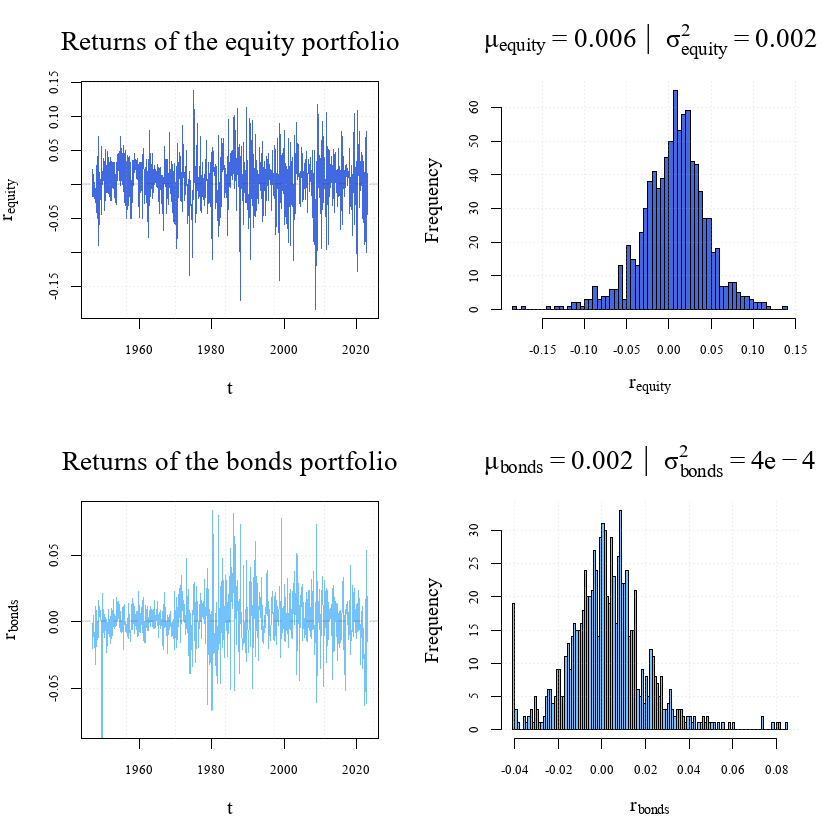

In [23]:
##
# 2.1 Infer the relative risk aversion (gamma)
#     based on real returns of equities and bonds
##

# Real returns using Fisher equation
rf             <- data7030$rf
rNominalEquity <- data7030$equity
rNominalBonds  <- data7030$bonds 
inflation      <- data7030$inflation

rRealRf        <- (1 + rf)             / (1 + inflation) - 1
rRealEquity    <- (1 + rNominalEquity) / (1 + inflation) - 1
rRealBonds     <- (1 + rNominalBonds)  / (1 + inflation) - 1

# First and second moments
muRealEquity      <- mean(rRealEquity)
muRealBonds       <- mean(rRealBonds)
sdRealEquity      <- sd(rRealEquity)
sdRealBonds       <- sd(rRealBonds)
varRealEquity     <- var(rRealEquity)
varRealBonds      <- var(rRealBonds)
corEquityBonds    <- cor(rRealEquity, rRealBonds)
covarEquityBonds  <- cov(rRealEquity, rRealBonds)
sharpeRatioEquity <- muRealEquity / sdRealEquity
sharpeRatioBonds  <- muRealBonds  / sdRealBonds

# Print table of moments
moments2Assets <- data.frame(
    asset       = c("equity", "bonds"),
    mean        = round(c(muRealEquity, muRealBonds), 4),
    sigma       = round(c(sdRealEquity, sdRealBonds), 4),
    sigma2      = round(c(varRealEquity, varRealBonds), 4),
    sharpeRatio = round(c(sharpeRatioEquity, sharpeRatioBonds), 4)
)

paste("Correlation cor(r_equity,r_bonds) =", round(corEquityBonds, 4))
paste("Covariance cov(r_equity,r_bonds) =", round(covarEquityBonds, 5))
paste("First (mean) and second (variance) moments:")
t(moments2Assets)
paste("------------------------------------------------------------")

# Inferred risk aversion using two-fund separation
weightEquity <- 0.70
numerator    <- muRealEquity - muRealBonds
denominator  <- weightEquity * (varRealEquity + varRealBonds - 2*covarEquityBonds) -
                (varRealBonds - covarEquityBonds)
gamma        <- numerator / denominator

paste("The inferred relative risk aversion (gamma) is", round(gamma, 4))
paste("------------------------------------------------------------")

# Plot real return distributions
date      <- data7030$date
colEquity <- "royalblue"
colBonds  <- "#73C2FB"
colAbline <- adjustcolor("black", alpha.f = 0.1)

par(mfrow = c(2,2), family = "Times New Roman")

# Equity: time series
t1 <- "Returns of the equity portfolio"
t2 <- TeX(paste("$\\mu_{equity} = ", round(muRealEquity, 3),
                "\\;|\\; \\sigma^2_{equity} = ", round(varRealEquity, 3), "$"))
x1 <- TeX("$t$")
y1 <- TeX("$r_{equity}$")
plot(date, rRealEquity, type = "l", main = t1, xlab = x1, ylab = y1,
     lwd = 1, col = colEquity, 
     cex.main=2,
     cex.lab = 1.5)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)

# Equity: histogram
hist(rRealEquity, breaks = 100, freq = TRUE, main = t2, xlab = TeX("$r_{equity}$"),
     col = colEquity,
     cex.main=2,
     cex.lab = 1.5)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

# Bonds: time series
t1 <- "Returns of the bonds portfolio"
t2 <- TeX(paste("$\\mu_{bonds} = ", round(muRealBonds, 3),
                "\\;|\\; \\sigma^2_{bonds} = ", round(varRealBonds, 4), "$"))
x1 <- TeX("$t$")
y1 <- TeX("$r_{bonds}$")

# truncate outliers (cleaner plot)
qL      <- quantile(rRealBonds, 0.02)
returns <- ifelse(rRealBonds > qL, rRealBonds, qL)

plot(date, rRealBonds, type = "l", main = t1, xlab = x1, ylab = y1,
     ylim = c(quantile(rRealBonds, 0.001), max(rRealBonds)),
     lwd = 1, col = colBonds,
     cex.main=2,
     cex.lab = 1.5)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)

# Bonds: histogram
hist(returns, breaks = 100, freq = TRUE, main = t2, xlab = TeX("$r_{bonds}$"),
     col = colBonds,
     cex.main=2,
     cex.lab = 1.5)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

[1] "Benchmark portfolio"

[1] "mu = 0.0044 sd = 0.03 SR = 0.1454 ce = 1.00258"

,round.wBenchmark..4.
,<dbl>
equity,0.7
bonds,0.3


[1] "-----------------------------------------------------------------------------------------------"

[1] "Tangency portolio, introducing risk free asset on excess retuns"

[1] "mu = 0.0039 sd = 0.0264 SR = 0.1465 ce = 1.00254"

,round.wTangency..4.
,<dbl>
equity,0.5672
bonds,0.4328


[1] "-----------------------------------------------------------------------------------------------"

[1] "The optimal leverage SR_Tangency/(gamma*sd_Tangency) is 1.249"

[1] "Unconstrained optimal portfolio, introducing risk free asset and given risk aversion"

[1] "mu = 0.0048 sd = 0.033 SR = 0.1465 ce = 1.00263"

,round.wUncWithRf..4.
,<dbl>
equity,0.7085
bonds,0.5405
rf,-0.2490


[1] "-----------------------------------------------------------------------------------------------"

[1] "Comparison between strategies"

,equity,bonds,mean,sd,SR,ce
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
wBenchmark,0.7000,0.3000,0.0044,0.0300,0.1454,1.0026
wTangency,0.5672,0.4328,0.0039,0.0264,0.1465,1.0025
wUncWithRf,0.7085,0.5405,0.0048,0.0330,0.1465,1.0026


[1] "-----------------------------------------------------------------------------------------------"

[1] "CE (Benchmark no rf)    = 1.00258"

[1] "CE (tangency)     = 1.00254"

[1] "CE (with rf)      = 1.00263"

[1] "CE improvement (rf - no rf = 5.2e-05"

[1] "-----------------------------------------------------------------------------------------------"

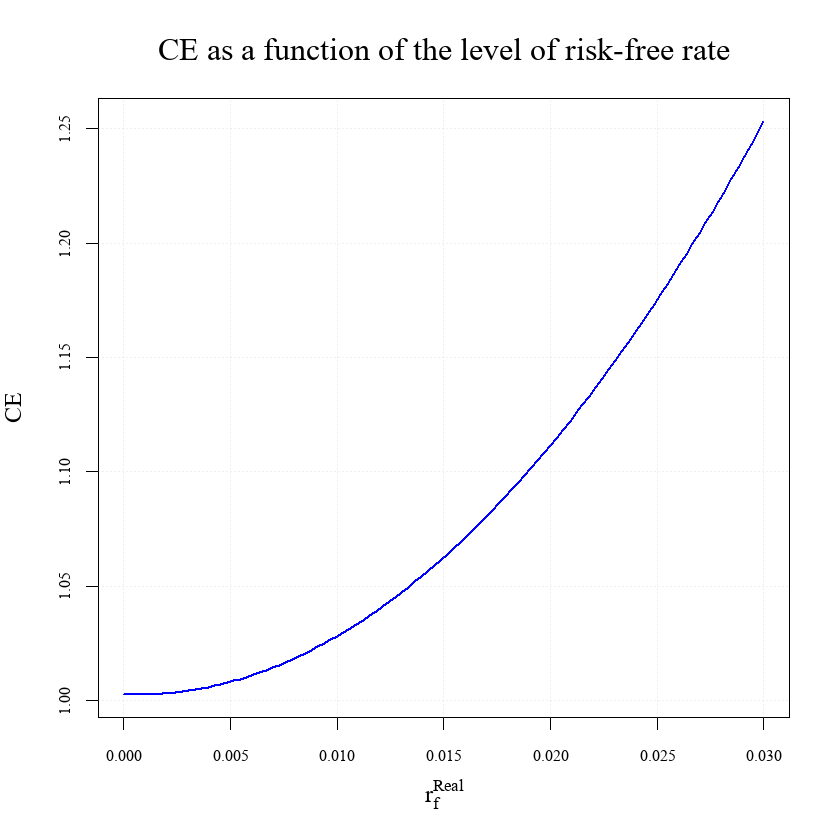

In [24]:
##
# 2.2 This Analyzes improvement in certainty equivalent if investing in rf
##

# Excess returns
rExcessEquity   <- rRealEquity - rRealRf
rExcessBonds    <- rRealBonds  - rRealRf
dataX           <- cbind(rExcessEquity, rExcessBonds)
colnames(dataX) <- c("equity","bonds")

mu    <- colMeans(dataX)
sigma <- cov(dataX)

# Unconstrained optimal portfolio (no rf)
wBenchmark           <- c( equity = 0.70, bonds = 0.30)
muBenchmark          <- c(wBenchmark %*% mu)
sdBenchmark          <- sqrt(c(wBenchmark %*% sigma %*% wBenchmark))
sharpeRatioBenchmark <- muBenchmark / sdBenchmark
ceBenchmark          <- 1 + mean(rRealRf) + (muBenchmark - 0.5 * gamma * sdBenchmark^2)  #1 + muBenchmark - 0.5 * gamma * sdBenchmark^2

paste("Benchmark portfolio")
paste("mu =", round(muBenchmark,4), "sd =", round(sdBenchmark,4),
      "SR =", round(sharpeRatioBenchmark,4), "ce =", round(ceBenchmark,5))
data.frame(round(wBenchmark,4))
paste("-----------------------------------------------------------------------------------------------")

# Tangency portfolio
wTangency        <- uncTangent(mu, sigma)
muTangency          <- c(wTangency %*% mu)
sdTangency          <- sqrt(c(wTangency %*% sigma %*% wTangency))
sharpeRatioTangency <- muTangency / sdTangency
ceTangency          <- 1 + mean(rRealRf) + (muTangency - 0.5 * gamma * sdTangency^2) # 1 + muTangency - 0.5 * gamma * sdTangency^2

paste("Tangency portolio, introducing risk free asset on excess retuns")
paste("mu =", round(muTangency,4), "sd =", round(sdTangency,4),
      "SR =", round(sharpeRatioTangency,4), "ce =", round(ceTangency,5))
data.frame(round(wTangency,4))
paste("-----------------------------------------------------------------------------------------------")

# Optimal portfolio including rf
optLeverage          <- as.numeric(sharpeRatioTangency / (gamma * sdTangency))
wEquityUncWithRf     <- optLeverage * wTangency["equity"]
wBondsUncWithRf      <- optLeverage * wTangency["bonds"]
wRf                  <- 1 - optLeverage
wUncWithRf           <- c(equity = wEquityUncWithRf,
                          bonds  = wBondsUncWithRf,
                          rf     = wRf)

muUncWithRf          <- optLeverage * muTangency
sdUncWithRf          <- optLeverage * sdTangency
sharpeRatioUncWithRf <- muUncWithRf / sdUncWithRf
ceWithRf             <- 1 + mean(rRealRf) + (muUncWithRf - 0.5 * gamma * sdUncWithRf^2)                             #1 + muUncWithRf - 0.5 * gamma * sdUncWithRf^2

paste("The optimal leverage SR_Tangency/(gamma*sd_Tangency) is", round(optLeverage,4))
paste("Unconstrained optimal portfolio, introducing risk free asset and given risk aversion")
paste("mu =", round(muUncWithRf,4), "sd =", round(sdUncWithRf,4),
      "SR =", round(sharpeRatioUncWithRf,4), "ce =", round(ceWithRf,5))
data.frame(round(wUncWithRf,4), row.names = c("equity","bonds","rf"))
paste("-----------------------------------------------------------------------------------------------")

# Comparison table
t <- data.frame(
        rbind(wBenchmark,
              wTangency,
              wUncWithRf = wUncWithRf[1:2]),
        mean = c(muBenchmark, muTangency, muUncWithRf),
        sd   = c(sdBenchmark, sdTangency, sdUncWithRf),
        SR   = c(sharpeRatioBenchmark, sharpeRatioTangency, sharpeRatioUncWithRf),
        ce   = c(ceBenchmark, ceTangency, ceWithRf)
     )

paste("Comparison between strategies")
round(t,4)
paste("-----------------------------------------------------------------------------------------------")

paste("CE (Benchmark no rf)    =", round(ceBenchmark,5))
paste("CE (tangency)     =", round(ceTangency,5))
paste("CE (with rf)      =", round(ceWithRf,5))
paste("CE improvement (rf - no rf =", round(ceWithRf - ceBenchmark,6))
paste("-----------------------------------------------------------------------------------------------")


##
#  CE as function of rf and portfolio weights with risk-free asset
##

# Raw means (not excess)
muRaw    <- colMeans(cbind(rRealEquity, rRealBonds))
sigmaRaw <- cov(cbind(rRealEquity, rRealBonds))

# Range of risk-free rates (0% to 3%)
rfGrid <- seq(0.00, 0.03, length.out = 100)

# Output storage
ceRf         <- rep(0, length(rfGrid))
weightEquity <- rep(0, length(rfGrid))
weightBonds  <- rep(0, length(rfGrid))
weightRf     <- rep(0, length(rfGrid))

for (i in 1:length(rfGrid)) {

    rf <- rfGrid[i]

    # Excess means change with rf
    muExcess <- muRaw - rf

    # Recompute tangency portfolio
    wTangencySim <- uncTangent(muExcess, sigmaRaw)

    # Tangency mean excess return
    muTanExcess <- t(wTangencySim) %*% muExcess
    sdTan        <- sqrt(t(wTangencySim) %*% sigmaRaw %*% wTangencySim)

    # Optimal leverage
    leverage <- (muTanExcess / sdTan) / (gamma * sdTan)

    # Portfolio weights
    weightEquity[i] <- leverage * wTangencySim[1]
    weightBonds[i]  <- leverage * wTangencySim[2]
    weightRf[i]     <- 1 - leverage

    # CE
    ceRf[i] <- 1 + rf + (leverage * muTanExcess) - 0.5 * gamma * (leverage * sdTan)^2
}

# Results: CE vs rf
par(mfrow = c(1,1), family = "Times New Roman")
plot(rfGrid, ceRf, type="l", lwd=2, col="blue",
     main="CE as a function of the level of risk-free rate",
     xlab= TeX("$r^{Real}_{f}$"), ylab=TeX("$CE$"),
     cex.main=2,
     cex.lab = 1.5)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

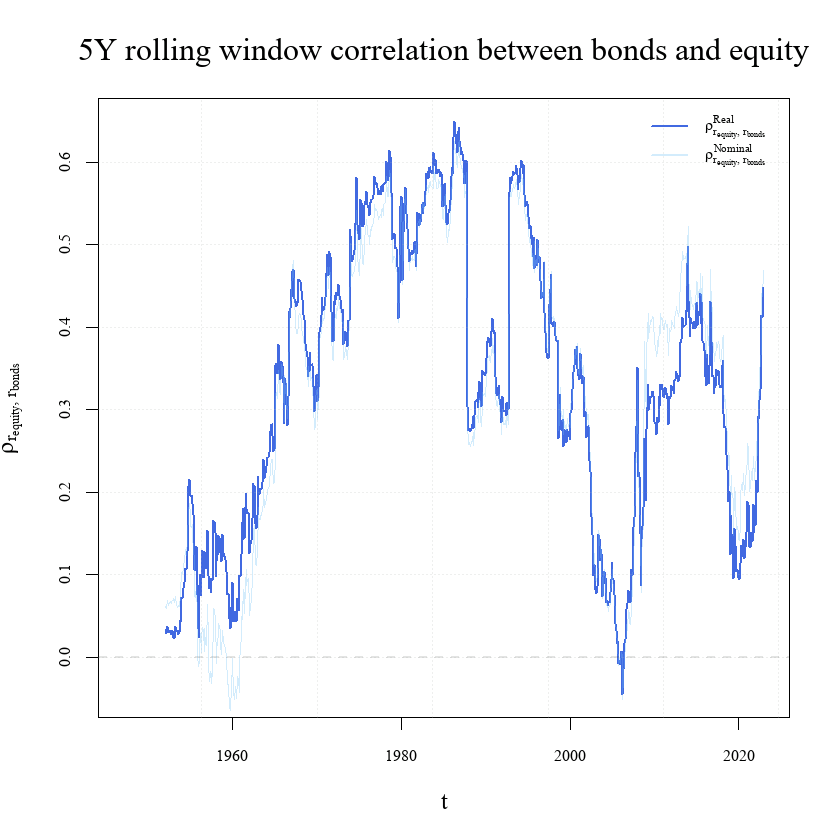

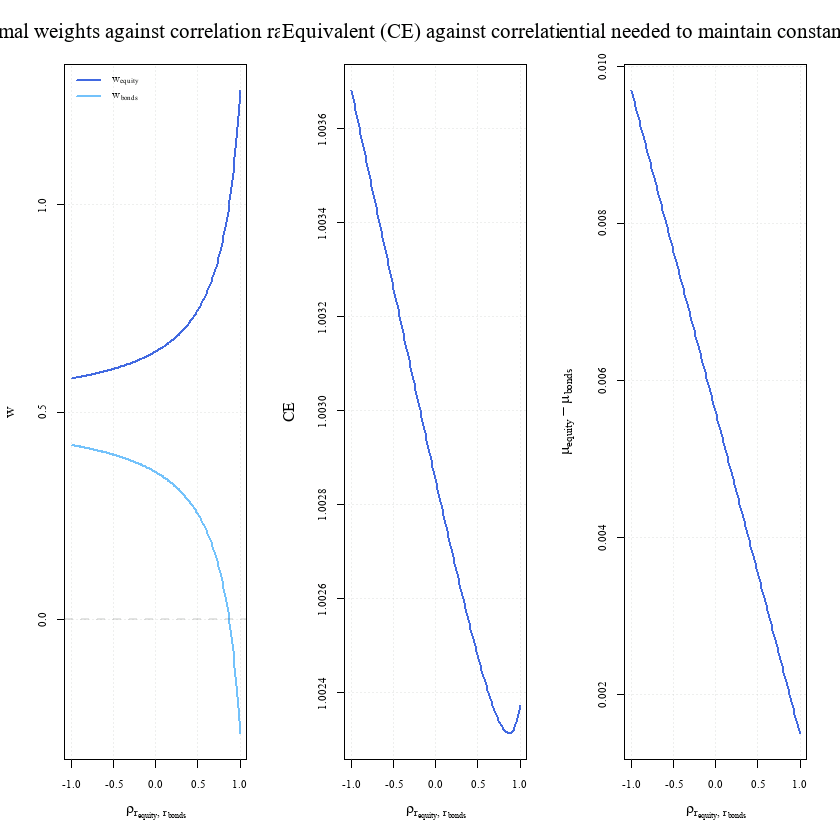

In [25]:
##
#  2.3 Plots 5Y rolling window correlation + finds optimal w and
#      ce over a relevant range of correlations + mean differential
#      to maintain constant portfolio weights
##

# Plot 5Y rolling window correlation between bonds and stocks
window                <- 60
xReal                 <- cbind(rRealEquity, rRealBonds)
rollWindowCorrReal    <- rollapply(
                                xReal,
                                width      = window,
                                FUN        = function(x) cor(x[,1], x[,2]),
                                by         = 1,
                                align      = "right",
                                fill       = NA,
                                by.column  = FALSE
                              )

xNominal              <- cbind(rNominalEquity, rNominalBonds)
rollWindowCorrNominal <- rollapply(
                                xNominal,
                                width      = window,
                                FUN        = function(x) cor(x[,1], x[,2]),
                                by         = 1,
                                align      = "right",
                                fill       = NA,
                                by.column  = FALSE
                              )

par(mfrow = c(1,1), family = "Times New Roman")
colReal    <- adjustcolor("royalblue", alpha.f = 1.0)
colNominal <- adjustcolor("#73C2FB", alpha.f = 0.3)
t          <- "5Y rolling window correlation between bonds and equity"

plot(date, rollWindowCorrReal, type = "l", col = colReal, lwd = 2, main = t,
     xlab = TeX("$t$"), ylab = TeX("$\\rho_{r_{equity},r_{bonds}}$"),
     cex.main=2,
     cex.lab = 1.5)
lines(date, rollWindowCorrNominal, col = colNominal,)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)

legend("topright",
       legend = c(TeX("$\\rho^{Real}_{r_{equity},r_{bonds}}$"),
                  TeX("$\\rho^{Nominal}_{r_{equity},r_{bonds}}$")),
       col = c(colReal, colNominal),
       lwd = 2,
       bg  = "white",
       bty = "n")


##
#  Analyze optimal portfolio and CE for a range of correlations
##

gamma  <- gamma
mu1    <- muRealEquity
mu2    <- muRealBonds
var1   <- varRealEquity
var2   <- varRealBonds
sigma1 <- sdRealEquity
sigma2 <- sdRealBonds
cor    <- seq(-1.0, 1.0, length.out = 200)

# Prepare storage vectors
w1  <- rep(0, length(cor))
w2  <- rep(0, length(cor))
mu  <- rep(0, length(cor))
var <- rep(0, length(cor))
sd  <- rep(0, length(cor))
ce  <- rep(0, length(cor))

# Solve for weights and MV certainty equivalent
for (i in 1:length(cor)) {

    cov12 <- cor[i] * sigma1 * sigma2

    w1[i] <- ((1/gamma) * (mu1 - mu2) + (var2 - cov12)) /
             (var1 + var2 - 2*cov12)

    w2[i] <- 1 - w1[i]

    mu[i]  <- w1[i]*mu1 + w2[i]*mu2
    var[i] <- w1[i]^2 * var1 + 2*w1[i]*w2[i]*cov12 + w2[i]^2*var2
    sd[i]  <- sqrt(var[i])

    ce[i]  <- 1 + mu[i] - 0.5 * gamma * sd[i]^2 
}

# Plot weights
par(mfrow = c(1,3))
yMin <- min(w1, w2)
yMax <- max(w1, w2)

t <- TeX("Optimal weights against correlation range -1:1")
plot(cor, w1, type = "l", col = "royalblue", ylim = c(yMin, yMax), lwd = 2,
     main = t, xlab = TeX("$\\rho_{r_{equity},r_{bonds}}$"), ylab = TeX("$w$"),
     cex.main=2,
     cex.lab = 1.5)
lines(cor, w2, col = "#73C2FB", lwd = 2)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)

legend("topleft",
       legend = c(TeX("$w_{equity}$"), TeX("$w_{bonds}$")),
       col    = c("royalblue", "#73C2FB"),
       lwd    = 2,
       bg     = "white",
       bty    = "n")


# Plot CE vs correlation
t <- TeX("Certainty Equivalent (CE) against correlation range -1:1")
plot(cor, ce, type = "l", col = "royalblue", lwd = 2, main = t,
     xlab = TeX("$\\rho_{r_{equity},r_{bonds}}$"), ylab = TeX("$CE$"),
     cex.main=2,
     cex.lab = 1.5)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)


##
#  Mean differential needed to maintain constant 70/30 portfolio
##

w1Target     <- 0.70
mu1Minusmu2  <- rep(0, length(cor))

for (i in 1:length(cor)) {

    cov12 <- cor[i] * sigma1 * sigma2

    mu1Minusmu2[i] <- gamma * w1Target * (var1 + var2 - 2*cov12) -
                      (var2 - cov12)
}

t <- TeX("Mean differential needed to maintain constant 70/30 weights")
plot(cor, mu1Minusmu2, type = "l", lwd = 2, col = "royalblue", main = t,
     xlab = TeX("$\\rho_{r_{equity},r_{bonds}}$"),
     ylab = TeX("$\\mu_{equity}-\\mu_{bonds}$"),
     cex.main=2,
     cex.lab = 1.5)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

par(mfrow = c(1,1))

In [26]:
##
#  2.4 Computes optimal weights under CRRA utility lognormal + historical
##

# Compute optimal weights under CRRA utility and lognormal returns
gamma              <- gamma
dataX              <- data.frame(equity = rExcessEquity, bonds = rExcessBonds)
mu                 <- colMeans(dataX)
sigma              <- cov(dataX)

wCrraLog           <- portCRRA(data = dataX, model = "lognorm", gamma = gamma)
muCrraLog          <- as.numeric(wCrraLog %*% mu)
sdCrraLog          <- sqrt(as.numeric(wCrraLog %*% sigma %*% wCrraLog))
sharpeRatioCrraLog <- muCrraLog / sdCrraLog

ptsGaussHermite    <- gauss.hermite(20)
pGaussHermite      <- ptsGaussHermite[, 2]
rExcessPortfolio   <- muCrraLog + sdCrraLog * ptsGaussHermite[, 1]
rPortfolio         <- 1 + rExcessPortfolio
ceCrraLog          <- (sum(pGaussHermite * rPortfolio^(1-gamma)))^(1/(1-gamma))

paste("Optimal weights under CRRA utility and lognormal returns")
paste("mu =", round(muCrraLog, 4),
      "sd =", round(sdCrraLog, 4),
      "SR =", round(sharpeRatioCrraLog, 4),
      "CE =", round(ceCrraLog, 4))
data.frame(round(wCrraLog,4), row.names = c("equity", "bonds"))
paste("-----------------------------------------------------------------------------------------------")

# Compare with mean variance ptf given a risk aversion (excess returns)
wMeanVariance           <- uncMeanVar_ra(mu, sigma, gamma)
muMeanVariance          <- as.numeric(wMeanVariance %*% mu)
sdMeanVariance          <- sqrt(as.numeric(wMeanVariance %*% sigma %*% wMeanVariance))
sharpeRatioMeanVariance <- muMeanVariance / sdMeanVariance
ceMeanVarianceNet       <- mean(rRealRf) + muMeanVariance - 0.5 * gamma * sdMeanVariance^2
ceMeanVariance          <- 1 + ceMeanVarianceNet


paste("Optimal weights under mean variance ptf given a risk aversion and rf (excess returns)")
paste("mu =", round(muMeanVariance, 4),
      "sd =", round(sdMeanVariance, 4),
      "SR =", round(sharpeRatioMeanVariance, 4),
      "CE =", round(ceMeanVariance, 4))
data.frame(round(wMeanVariance,4), row.names = c("equity", "bonds"))
paste("-----------------------------------------------------------------------------------------------")

# CRRA with historical simulation
grossRf                   <- mean(1 + rRealRf)
wCrraHistorical           <- portCRRA(data = dataX, model = "hist", gamma = gamma, Rf = grossRf)
muCrraHistorical          <- as.numeric(wCrraHistorical %*% mu)
sdCrraHistorical          <- sqrt(as.numeric(wCrraHistorical %*% sigma %*% wCrraHistorical))
sharpeRatioCrraHistorical <- muCrraHistorical / sdCrraHistorical

rExcessPortfolio          <- as.numeric(as.matrix(dataX) %*% wCrraHistorical)
ceCrraHistorical          <- (mean((grossRf * (1 + rExcessPortfolio))^(1-gamma)))^(1/(1-gamma))

paste("Optimal weights under CRRA utility and historical simulation")
paste("mu =", round(muCrraHistorical, 4),
      "sd =", round(sdCrraHistorical, 4),
      "SR =", round(sharpeRatioCrraHistorical, 4),
      "CE =", round(ceCrraHistorical, 4))
data.frame(round(wCrraHistorical,5), row.names = c("equity", "bonds"))
paste("-----------------------------------------------------------------------------------------------")

# Compare strategies
t <- data.frame(
        rbind(wCrraLog, wMeanVariance, wCrraHistorical),
        mean = c(muCrraLog, muMeanVariance, muCrraHistorical),
        sd   = c(sdCrraLog, sdMeanVariance, sdCrraHistorical),
        SR   = c(sharpeRatioCrraLog, sharpeRatioMeanVariance, sharpeRatioCrraHistorical),
        ce   = c(ceCrraLog, ceMeanVariance, ceCrraHistorical)
     )
paste("Comparison between strategies")
round(t, 4)

[1] "Optimal weights under CRRA utility and lognormal returns"

[1] "mu = 0.0043 sd = 0.0293 SR = 0.1457 CE = 1.0024"

,round.wCrraLog..4.
,<dbl>
equity,0.6760
bonds,0.3237


[1] "-----------------------------------------------------------------------------------------------"

[1] "Optimal weights under mean variance ptf given a risk aversion and rf (excess returns)"

[1] "mu = 0.0043 sd = 0.0297 SR = 0.1456 CE = 1.0026"

,round.wMeanVariance..4.
,<dbl>
equity,0.6871
bonds,0.3129


[1] "-----------------------------------------------------------------------------------------------"

[1] "Optimal weights under CRRA utility and historical simulation"

[1] "mu = 0.0042 sd = 0.0288 SR = 0.146 CE = 1.0025"

,round.wCrraHistorical..5.
,<dbl>
equity,0.65649
bonds,0.34345


[1] "-----------------------------------------------------------------------------------------------"

[1] "Comparison between strategies"

,equity,bonds,mean,sd,SR,ce
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
wCrraLog,0.6760,0.3237,0.0043,0.0293,0.1457,1.0024
wMeanVariance,0.6871,0.3129,0.0043,0.0297,0.1456,1.0026
wCrraHistorical,0.6565,0.3435,0.0042,0.0288,0.1460,1.0025


[1] "Optimal weights under MV portfolio without the rf asset"

[1] "mu = 0.0044 sd = 0.0294 SR = 0.1509 CE = 1.0027"

,round.wMeanVarianceNoRf..4.
,<dbl>
developed,-0.2180
emerging,0.1561
equity,0.7604
bonds,0.5497
bondsExUS,-0.2482


[1] "-----------------------------------------------------------------------------------------------"

[1] "Optimal weights under the tangenct portfolio withe the rf asset"

[1] "mu = 0.0037 sd = 0.0241 SR = 0.1533 CE = 1.00262"

,round.wTangencyRf..4.
,<dbl>
developed,-0.1755
emerging,0.1245
equity,0.5718
bonds,0.9275
bondsExUS,-0.4483


[1] "-----------------------------------------------------------------------------------------------"

,developed,emerging,equity,bonds,bondsExUS,mean,sd,SR,ce
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
wBenchmark,0.000,0.0000,0.7000,0.3000,0.0000,0.0044,0.0300,0.1454,1.0026
wMeanVarianceNoRf,-0.218,0.1561,0.7604,0.5497,-0.2482,0.0044,0.0294,0.1509,1.0027


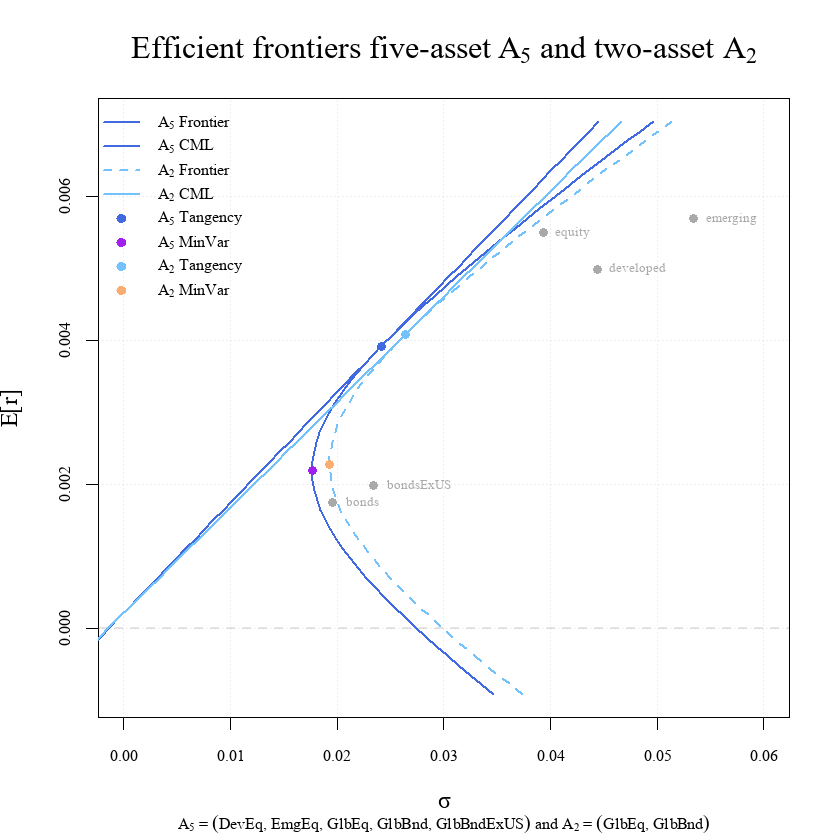

In [27]:
##
#  2.5 Mean variance analysis incorporating more than two asset classes
##

# Gets the selected indices to be incorporated
# dvlp_eq	 GFD Indices Developed World x/North America Return Index
# emrg_eq	 GFD Indices Emerging Markets Return Index
# wrld_eq	 GFD Indices All World Return Index
# wrld_gbnd	 GFD Indices World Government Bond GDP-weighted Return Index
# wrldx_gbnd GFD Indices World x/USA Countries Government Bond GDP-weighted Return Index
assets          <- c("dvlp_eq", "emrg_eq", "wrld_eq", "wlrd_gbnd", "wrldx_gbnd")
dataX           <- data[-1, assets]
colnames(dataX) <- c("developed", "emerging", "equity", "bonds", "bondsExUS")
rRealRf         <- rRealRf
inflation       <- inflation
dataReal        <- (1 + dataX) / (1 + inflation) - 1 
dataExcess      <- dataReal - rRealRf


# Compute MV portfolio without the rf asset,
mu                          <- colMeans(dataExcess)
sigma                       <- cov(dataExcess)
gamma                       <- gamma
wMeanVarianceNoRf           <- uncMeanVar_ra(mu, sigma, gamma)
muMeanVarianceNoRf          <- as.numeric(wMeanVarianceNoRf %*% mu)
sdMeanVarianceNoRf          <- sqrt(as.numeric(wMeanVarianceNoRf %*% sigma %*% wMeanVarianceNoRf))
sharpeRatioMeanVarianceNoRf <- (wMeanVarianceNoRf %*% mu) / (sqrt(wMeanVarianceNoRf %*% sigma %*% wMeanVarianceNoRf))
ceMeanVarianceNoRf          <- 1 + mean(rRealRf) + muMeanVarianceNoRf - 0.5*gamma*sdMeanVarianceNoRf^2


paste("Optimal weights under MV portfolio without the rf asset")
paste("mu =", round(muMeanVarianceNoRf, 4), "sd =", round(sdMeanVarianceNoRf, 4), "SR =", round(sharpeRatioMeanVarianceNoRf, 4), "CE =", round(ceMeanVarianceNoRf, 4))
data.frame(round(wMeanVarianceNoRf, 4), row.names = c("developed", "emerging", "equity", "bonds", "bondsExUS"))
paste("-----------------------------------------------------------------------------------------------")

# Compute the tangenct portfolio withe the rf asset
mu                          <- colMeans(dataExcess)
sigma                       <- cov(dataExcess)
gamma                       <- gamma
wTangencyRf                 <- uncTangent(mu, sigma)
muTangencyRf                <- as.numeric(wTangencyRf %*% mu)
sdTangencyRf                <- sqrt(as.numeric(wTangencyRf %*% sigma %*% wTangencyRf))
sharpeRatioTangencyRf       <- (wTangencyRf %*% mu) / (sqrt(wTangencyRf %*% sigma %*% wTangencyRf))
ceTangencyRf                <- 1 + mean(rRealRf) + muTangencyRf - 0.5*gamma*sdTangencyRf^2


paste("Optimal weights under the tangenct portfolio withe the rf asset")
paste("mu =", round(muTangencyRf, 4), "sd =", round(sdTangencyRf, 4), "SR =", round(sharpeRatioTangencyRf, 4), "CE =", round(ceTangencyRf, 5))
data.frame(round(wTangencyRf, 4), row.names = c("developed", "emerging", "equity", "bonds", "bondsExUS"))
paste("-----------------------------------------------------------------------------------------------")

# Plot the efficient frontier without rf
mu               <- colMeans(dataExcess)
sigma            <- cov(dataExcess)
rf               <- mean(rRealRf)

# Start with the 5 assets ptf
wTangencyRf      <- wTangencyRf
muTangencyRf     <- muTangencyRf
sdTangencyRf     <- sdTangencyRf

wMinVariance     <- portMinVar(sigma)
muMinVariance    <- as.numeric(t(wMinVariance) %*% mu)
sdMinVariance    <- sqrt(as.numeric(t(wMinVariance) %*% sigma %*% wMinVariance))

rangeMu <- seq(from = -0.2 * max(mu),
               to   =  1.2 * max(mu),
               length.out = 60)

M <- matrix(NA, nrow = length(rangeMu), ncol = 4)

i <- 1
for(muTarget in rangeMu){

    wPtf         <- uncMeanVar_mu(mu, sigma, muTarget)
    muNoRf       <- rf + as.numeric(t(wPtf) %*% mu)
    sdNoRf       <- sqrt(as.numeric(t(wPtf) %*% sigma %*% wPtf))

    leverage     <- muTarget / muTangencyRf
    muRfLine     <- rf + muTarget
    sdRfLine     <- leverage * sdTangencyRf

    M[i, ]       <- c(muNoRf, sdNoRf, muRfLine, sdRfLine)
    i <- i + 1
}

# Continue with equity and bonds ptf
dataTwoAssets  <- dataExcess[, c("equity", "bonds")]
muTwoAssets    <- colMeans(dataTwoAssets)
sigmaTwoAssets <- cov(dataTwoAssets)

wTangencyTwo   <- uncTangent(muTwoAssets, sigmaTwoAssets)
muTangencyTwo  <- as.numeric(t(wTangencyTwo) %*% muTwoAssets)
sdTangencyTwo  <- sqrt(as.numeric(t(wTangencyTwo) %*% sigmaTwoAssets %*% wTangencyTwo))

wMinVarTwo     <- portMinVar(sigmaTwoAssets)
muMinVarTwo    <- as.numeric(t(wMinVarTwo) %*% muTwoAssets)
sdMinVarTwo    <- sqrt(as.numeric(t(wMinVarTwo) %*% sigmaTwoAssets %*% wMinVarTwo))

TTwo <- matrix(NA, nrow = length(rangeMu), ncol = 4)

i <- 1
for(muTarget in rangeMu){

    wTwo        <- uncMeanVar_mu(muTwoAssets, sigmaTwoAssets, muTarget)
    muNoRfTwo   <- rf + as.numeric(t(wTwo) %*% muTwoAssets)
    sdNoRfTwo   <- sqrt(as.numeric(t(wTwo) %*% sigmaTwoAssets %*% wTwo))

    leverageTwo <- muTarget / muTangencyTwo
    muRfTwo     <- rf + muTarget
    sdRfTwo     <- leverageTwo * sdTangencyTwo

    TTwo[i, ]   <- c(muNoRfTwo, sdNoRfTwo, muRfTwo, sdRfTwo)
    i <- i + 1
}

# Plot
par(mfrow = c(1,1), family = "Times New Roman")
plot(M[,2], M[,1], type="l", lwd=2, col="royalblue",
     xlim = c(0,0.06),
     xlab= TeX("$\\sigma$"), ylab= TeX("$\\E[r]$"),
     cex.main=2,
     cex.lab = 1.5,
     main= TeX("Efficient frontiers five-asset $A_{5}$ and two-asset $A_2$"),
     sub = TeX("$A_{5}=(DevEq,EmgEq,GlbEq,GlbBnd,GlbBndExUS)$ and $A_2=(GlbEq,GlbBnd)$"))

lines(M[,4], M[,3], col="royalblue", lwd=2)
lines(TTwo[,2], TTwo[,1], col="#73C2FB", lwd=2, lty=2)
lines(TTwo[,4], TTwo[,3], col="#73C2FB", lwd=2, lty=1)

points(sdTangencyRf,  rf + muTangencyRf,  pch=19, col="royalblue")
points(sdMinVariance, rf + muMinVariance, pch=19, col="purple")
points(sdTangencyTwo, rf + muTangencyTwo, pch=19, col="#73C2FB")
points(sdMinVarTwo,   rf + muMinVarTwo,   pch=19, col="#FBAC73")

########
# Add points for each asset
assetNames  <- c("developed", "emerging", "equity", "bonds", "bondsExUS")
assetMus    <- colMeans(dataExcess)
assetSigmas <- apply(dataExcess, 2, sd)

points(assetSigmas, assetMus, pch = 16, col = "darkgray")

# Add the text label next to each point
# 'pos=4' means the text is placed to the right of the point. 
# 'cex' controls the size of the text.
text(x = assetSigmas, 
     y = assetMus, 
     labels = assetNames, 
     pos = 4, 
     cex = 0.8,
     col = "darkgray")
########


grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)

legend("topleft",
       legend=c(TeX("$A_{5}$ Frontier"), TeX("$A_{5}$ CML"),
                TeX("$A_{2}$ Frontier"), TeX("$A_{2}$ CML"),
                TeX("$A_{5}$ Tangency"), TeX("$A_{5}$ MinVar"),
                TeX("$A_{2}$ Tangency"), TeX("$A_{2}$ MinVar")),
       col=c("royalblue","royalblue","#73C2FB","#73C2FB","royalblue","purple","#73C2FB","#FBAC73"),
       lty=c(1,1,2,1,NA,NA,NA,NA),
       pch=c(NA,NA,NA,NA,19,19,19,19),
       lwd=2, bty = "n")

# Compare against benchmark strategy
wBenchmark           <- c(0.0, 0.0, 0.70, 0.30, 0)   
mu                   <- colMeans(dataExcess)
sigma                <- cov(dataExcess)
muBenchmark          <- as.numeric(wBenchmark %*% mu)
sdBenchmark          <- sqrt(as.numeric(t(wBenchmark) %*% sigma %*% wBenchmark))
sharpeRatioBenchmark <- muBenchmark / sdBenchmark
ceBenchmark          <- 1 + mean(rRealRf) + muBenchmark - 0.5 * gamma * sdBenchmark^2

t <- data.frame(rbind(wBenchmark, wMeanVarianceNoRf), mean = c(muBenchmark, muMeanVarianceNoRf),
               sd = c(sdBenchmark, sdMeanVarianceNoRf), SR = c(sharpeRatioBenchmark, sharpeRatioMeanVarianceNoRf),
               ce = c(ceBenchmark, ceMeanVarianceNoRf)
               )
round(t, 4)

In [28]:
##
#  3.0 Add NTW into account (i) no leverage or ptf constraints
#      and (ii) restricted leverage or short-selling
##

# Get the right time series for the length of oil as NTW returns
variables         <- c("date","us_t1m", "us_infl", "oil", "wrld_eq", "wlrd_gbnd")
dataNtw           <- na.omit(data[, variables])
colnames(dataNtw) <- c("date", "rf", "inflation", "oil", "equity", "bonds")

# Convert to REAL excess returns
dataNtw$rf     <- (1 + dataNtw$rf)     / (1 + dataNtw$inflation) - 1
dataNtw$equity <- (1 + dataNtw$equity) / (1 + dataNtw$inflation) - 1
dataNtw$bonds  <- (1 + dataNtw$bonds)  / (1 + dataNtw$inflation) - 1

dataNtw$equity <- dataNtw$equity - dataNtw$rf
dataNtw$bonds  <- dataNtw$bonds  - dataNtw$rf

# Define NTW variable
rNtw <- dataNtw$oil

# Data for risky assets
assets  <- c("equity", "bonds")
dataX   <- dataNtw[, assets]
gamma   <- gamma
mu      <- colMeans(dataX)
sigma   <- cov(dataX)

# Covariance of NTW with risky assets
sigmaN  <- cov(rNtw, dataX)
sigmaN  <- matrix(as.numeric(sigmaN), ncol = 1)

# Hedge coefficients (Campbell–Viceira)
betaN   <- inv(sigma) %*% as.numeric(sigmaN)

# NTW share y
y <- 0.25

###
#  IMPORTANT: USE THE BENCHMARK AS THE MYOPIC PORTFOLIO
#  Because benchmark = optimal myopic allocation
###

xMyopicBenchmark <- c(equity = 0.70, bonds = 0.30)

# Compute unconstrained hedge demand
xHedgeUnc  <- (y / (1 - y)) * betaN
xHedgeUnc  <- c(equity = xHedgeUnc[1], bonds = xHedgeUnc[2])

# Total NTW-adjusted unconstrained portfolio
xUnc <- xMyopicBenchmark - xHedgeUnc

# Portfolio statistics
muUnc  <- y*mean(rNtw) + (1-y)*(mean(dataNtw$rf) + t(xUnc)%*%mu)
varUnc <- y^2 * sd(rNtw)^2 +
          (1-y)^2 * t(xUnc)%*%sigma%*%xUnc +
          2*y*(1-y)*t(xUnc)%*%sigmaN

sdUnc  <- sqrt(varUnc)
sharpeRatioUnc <- muUnc / sdUnc
ceUnc  <- 1 + muUnc - 0.5*gamma*sdUnc^2

paste("The beta of equity is", round(betaN[1], 4), "and beta of bonds is", round(betaN[2], 4))
paste("-----------------------------------------------------------------------------------------------")

paste("Optimal weights under unconstrained ptf based on benchmark and NTW")
paste("mu =", round(muUnc, 4), "sd =", round(sdUnc, 4),
      "SR =", round(sharpeRatioUnc, 4), "CE =", round(ceUnc, 4))
data.frame(round(xUnc, 4), row.names = c("equity", "bonds"))
paste("-----------------------------------------------------------------------------------------------")

##
#  Constrained NTW portfolio: no short selling, no leverage
##

# Start with benchmark again
xMyopicCon <- xMyopicBenchmark

# Hedge demand same logic
xHedgeCon <- (y / (1 - y)) * betaN
xHedgeCon <- c(equity = xHedgeCon[1], bonds = xHedgeCon[2])

# Total constrained weights
xCon <- xMyopicCon - xHedgeCon

# Impose constraints
xCon <- pmax(xCon, 0)
xCon <- xCon / sum(xCon)

# Statistics
muCon  <- y*mean(rNtw) + (1-y)*(mean(dataNtw$rf) + t(xCon)%*%mu)
varCon <- y^2 * sd(rNtw)^2 +
          (1-y)^2 * t(xCon)%*%sigma%*%xCon +
          2*y*(1-y)*t(xCon)%*%sigmaN

sdCon          <- sqrt(varCon)
sharpeRatioCon <- muCon / sdCon
ceCon          <- 1 + muCon - 0.5*gamma*sdCon^2

paste("Optimal weights under constrained ptf based on benchmark and NTW")
paste("mu =", round(muCon, 4), "sd =", round(sdCon, 4),
      "SR =", round(sharpeRatioCon, 4), "CE =", round(ceCon, 4))
data.frame(round(xCon, 4), row.names = c("equity", "bonds"))
paste("-----------------------------------------------------------------------------------------------")

##
# Compare strategies
##

wBenchmark <- c(equity = 0.70, bonds = 0.30)

t <- data.frame(
      rbind(wBenchmark, xUnc, xCon),
      mean = c(muBenchmark, muUnc, muCon),
      sd   = c(sdBenchmark, sdUnc, sdCon),
      SR   = c(sharpeRatioBenchmark, sharpeRatioUnc, sharpeRatioCon),
      ce   = c(ceBenchmark, ceUnc, ceCon)
)

paste("Comparison between strategies")
round(t, 4)

[1] "The beta of equity is 0.4362 and beta of bonds is -0.4979"

[1] "-----------------------------------------------------------------------------------------------"

[1] "Optimal weights under unconstrained ptf based on benchmark and NTW"

[1] "mu = 0.0057 sd = 0.035 SR = 0.1618 CE = 1.0029"

,round.xUnc..4.
,<dbl>
equity,0.5546
bonds,0.4660


[1] "-----------------------------------------------------------------------------------------------"

[1] "Optimal weights under constrained ptf based on benchmark and NTW"

[1] "mu = 0.0056 sd = 0.0347 SR = 0.1616 CE = 1.0029"

,round.xCon..4.
,<dbl>
equity,0.5434
bonds,0.4566


[1] "-----------------------------------------------------------------------------------------------"

[1] "Comparison between strategies"

,equity,bonds,mean,sd,SR,ce
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
wBenchmark,0.7000,0.3000,0.0044,0.0300,0.1454,1.0026
xUnc,0.5546,0.4660,0.0057,0.0350,0.1618,1.0029
xCon,0.5434,0.4566,0.0056,0.0347,0.1616,1.0029


[1] "Optimal weights ptf under CRRA Utility (historical) and horizon 20Y (240M) with no rf asset"

,round.wCrraLogT..4.
,<dbl>
equity,0.6803
bonds,0.3197


[1] "-----------------------------------------------------------------------------------------------"

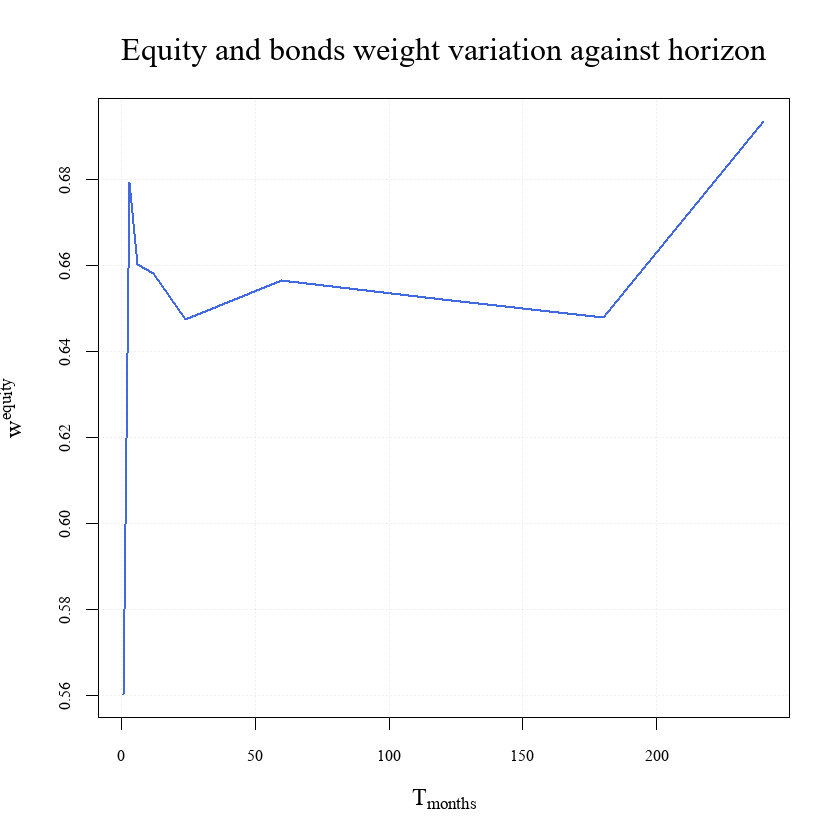

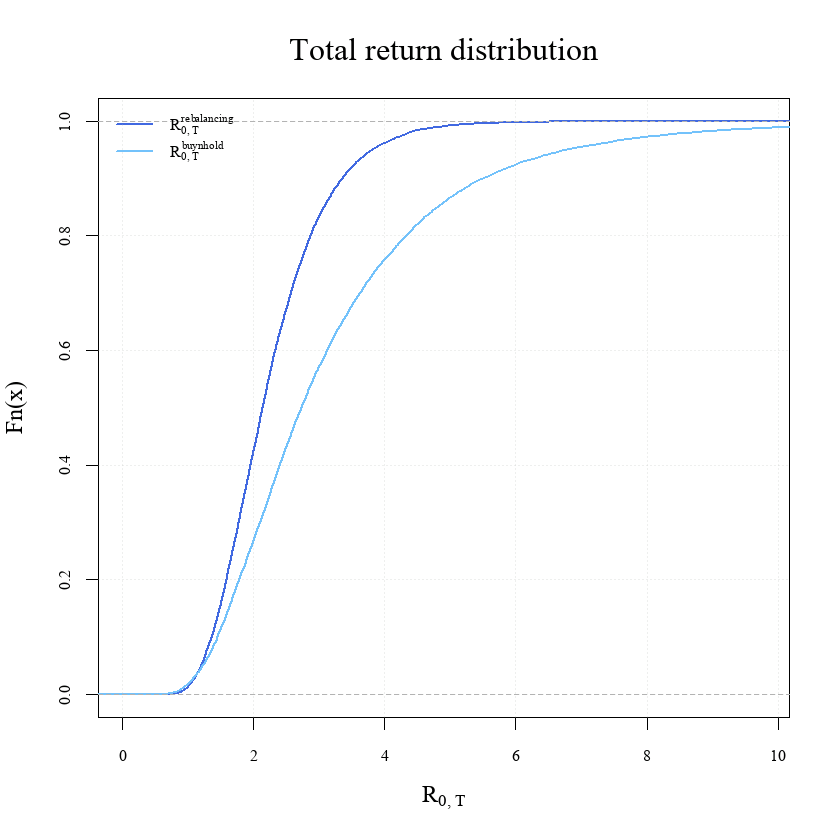

[1] "-----------------------------------------------------------------------------------------------"

[1] "Statistics computed on Geometric Mean returns (%)"

,Rebalanced,Buy-and-hold
Mean,0.3172,0.4288
Median,0.3169,0.4196
Std,0.1464,0.2183
Skew,0.0443,0.2262
Kurt,2.9412,3.0338
CE,1.7418,1.8556


[1] "-----------------------------------------------------------------------------------------------"

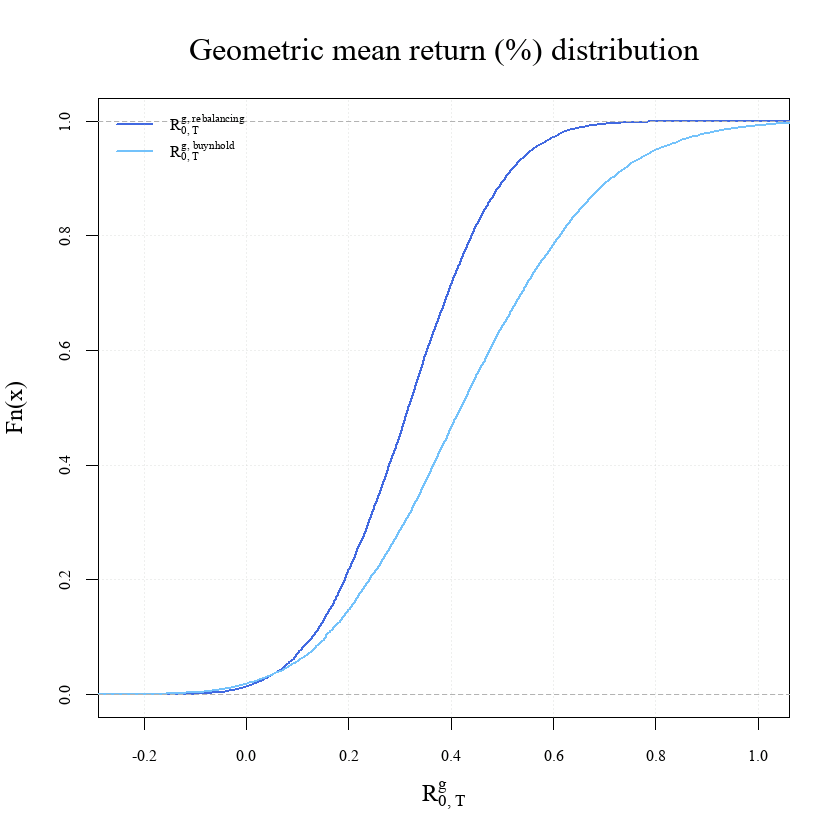

[1] "-----------------------------------------------------------------------------------------------"

[1] "Average 20Y turnover (rebalanced strategy) is 82.5014"

[1] "-----------------------------------------------------------------------------------------------"

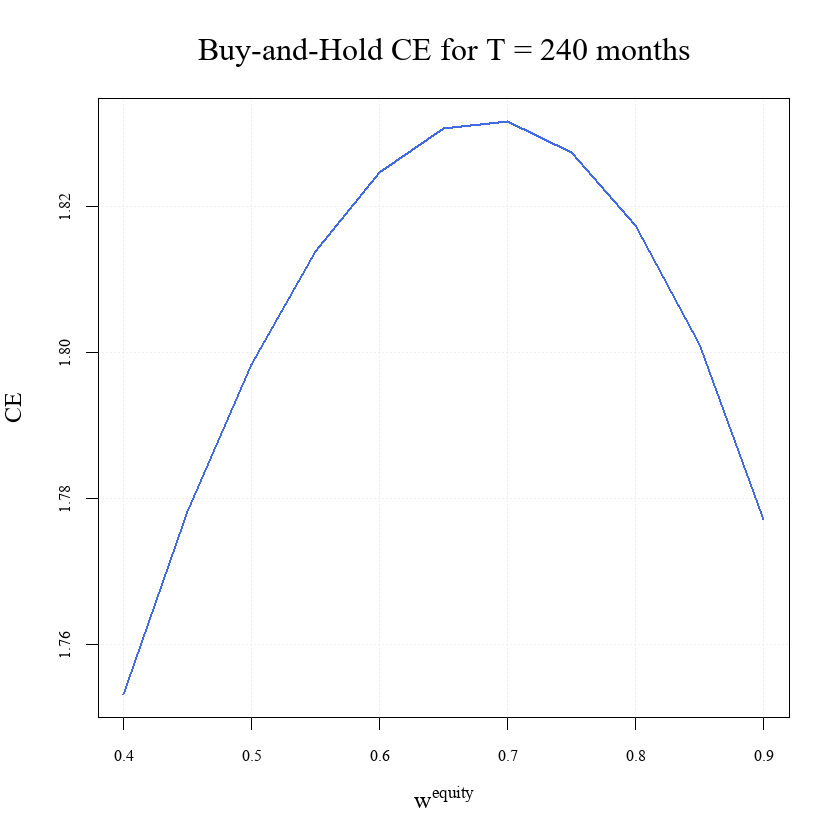

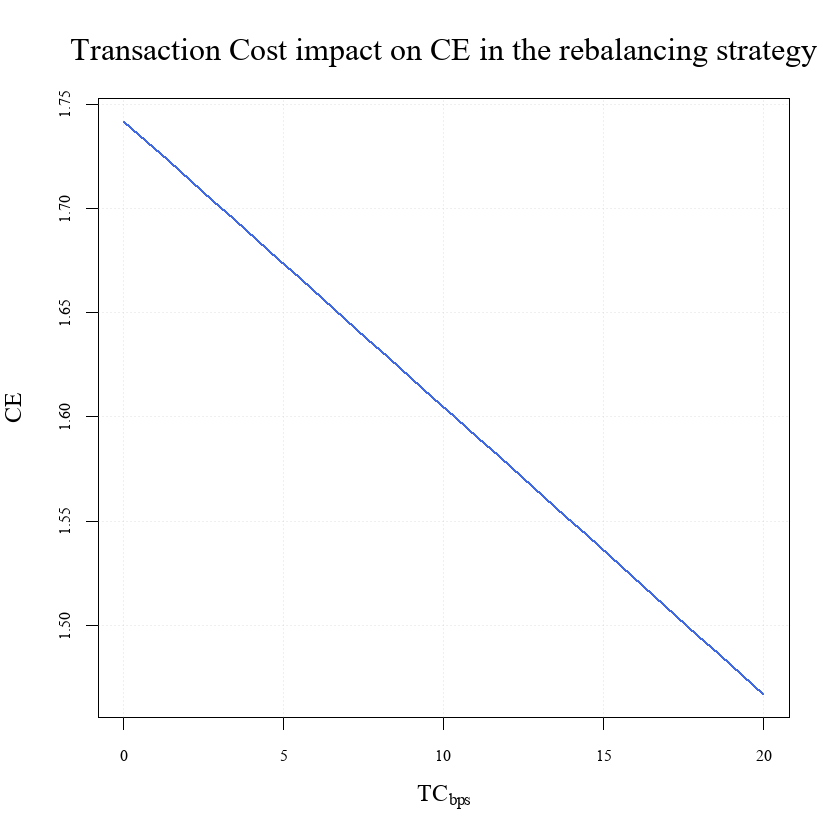

In [29]:
## ##CRRA PTF####
#  4.1 Assume constant IOS and log normal returns to compare rebalancing
#  and buy and hold strategies for a horizon of 20 years, CRRA utility ptf
##

# Excess returns data, mu, sigma, number of assets
dataX    <- data.frame(cbind(equity = dataExcess$equity, bonds = dataExcess$bonds))
dataRf   <- data.frame(rf = c(rRealRf))
muExcess <- colMeans(dataX)
sigma    <- cov(dataX)
nAssets  <- length(muExcess)

# Compute the best optimal portfollio without rf asset for a given horizon (20 Y)
T                 <- 12 * 20
gamma             <- gamma 
yT                <- mean(rRealRf)
optimalPortfolio  <- portCRRA_LT(data = 1 + yT + dataX, model = "hist", T = T, gamma = gamma, N = 10000) 
wCrraLogT         <- optimalPortfolio$w

paste("Optimal weights ptf under CRRA Utility (historical) and horizon 20Y (240M) with no rf asset")
data.frame(round(wCrraLogT, 4))
paste("-----------------------------------------------------------------------------------------------")

# Assuming IID, optimal static ptf under varying horizon. Various horizons: in months
T  <- c(1, 3, 6, 12, 24, 60, 120, 180, 240)
nT <- length(T)

#create arrays to store portfolio weights and certainty equivalent
weights             <- array(0, c(nT, nAssets))
certaintyEquivalent <- array(0, c(nT, 1))

for (i in 1:nT){
    # perform optimization for each horizon T
    optimalPortfolio       <- portCRRA_LT(data=1 + yT + dataX, model="hist", T=T[i], rf=NA, gamma=gamma, N=10000)

    # collect result: portfolio weights and certainty equivalent
    weights[i,]            <- optimalPortfolio$w
    certaintyEquivalent[i] <- optimalPortfolio$ce
}

# Plot the equity of the stock against horizon
par(mfrow = c(1,1), family = "Times New Roman")
plot(T, weights[,1], type="l", lwd=2, col="royalblue", main= "Equity and bonds weight variation against horizon", 
     xlab = TeX("$T_{months}$"),  ylab= TeX("$w^{equity}"),
     cex.main=2,
     cex.lab = 1.5,)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

##
# Rebalancing vs Buy and Hold
##

# Sets the paremeters
T            <- 12 * 20
nSimulations <- 10000

# Choose buy-and-hold strategy: isBnhShort = TRUE starts one-period, isBnhShort = FALSE long-term optimal ptf
isBnhShort <- FALSE

# Optimal one period portfolio: rebalancing strategy
optimalPortfolio <- portCRRA_LT(data=1 + yT + dataX, model="hist", T=1, rf=NA, gamma=gamma)
wRebal           <- as.matrix(optimalPortfolio$w)

#buy and hold strategy
if (isBnhShort == TRUE){
    #optimal short term portfolio
    wBnH <- wRebal
    } else {
    #optimal static long-run portfolio
    optimalPortfolio <- portCRRA_LT(data=1 + yT + dataX, model="hist", T=T, rf=NA, gamma=gamma)
    wBnH             <- as.matrix(optimalPortfolio$w)
    }

rRebal  <- rep(0, times=nSimulations)
rBnH    <- rep(0, times=nSimulations)

muLn    <- colMeans(log(1 + yT + dataX))
sigmaLn <- cov(log(1 + yT + dataX))

Rpaths  <- array(0, dim = c(nSimulations, T, 2))
for (i in 1:nSimulations){
    #asset returns
    R           <- exp(mvrnorm(T, muLn, sigmaLn))
    Rpaths[i,,] <- R
    r           <- log(R)
    
    #rebalanced portfolio log total return
    rRebal[i] <- sum(log(R %*% wRebal))
    
    #buy-and-hold portfolio log total return
    rBnH[i] <- log(exp(colSums(r)) %*% wBnH)
}

# Plot the two distributions of total returns
ecdfRebal <- ecdf(exp(rRebal))
ecdfBnH   <- ecdf(exp(rBnH))

plot(ecdfRebal, verticals=TRUE, do.points=FALSE, main="Total return distribution", col="royalblue", xlab= TeX("$R_{0,T}$"),
     cex.main=2,
     cex.lab = 1.5, lwd = 2)
plot(ecdfBnH,   verticals=TRUE, do.points=FALSE, add=TRUE, col="#73C2FB", lwd = 2)
legend(x = "topleft", legend = c(TeX("$R^{rebalancing}_{0,T}$"), TeX("$R^{buynhold}_{0,T}$")), col = c("royalblue", "#73C2FB"), lwd = 2, bty = "n")
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

# Plot the two distributions of geometric means
gmRebal     <- 100*(exp(rRebal / T) - 1)
gmBnH       <- 100*(exp(rBnH / T) - 1)
ecdfGmRebal <- ecdf(gmRebal)
ecdfGmBnH   <- ecdf(gmBnH)

plot(ecdfGmRebal, verticals=TRUE, do.points=FALSE, main="Geometric mean return (%) distribution", col="royalblue", xlab=TeX("$R^{g}_{0,T}$"),
     cex.main=2,
     cex.lab = 1.5, lwd = 2)
plot(ecdfGmBnH, verticals=TRUE, do.points=FALSE, add=TRUE, col="#73C2FB", lwd = 2)
legend(x = "topleft", legend = c(TeX("$R^{g,rebalancing}_{0,T}$"), TeX("$R^{g,buynhold}_{0,T}$")), col = c("royalblue", "#73C2FB"), lwd = 2, bty = "n")
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)


# Statistics of the geometric means of the two strategies
stats           <- matrix(0, nrow=6, ncol=2)
colnames(stats) <- c("Rebalanced", "Buy-and-hold")
rownames(stats) <- c("Mean", "Median", "Std", "Skew", "Kurt", "CE")
stats[1,]       <- c(mean(gmRebal), mean(gmBnH))
stats[2,]       <- c(median(gmRebal), median(gmBnH))
stats[3,]       <- c(sd(gmRebal), sd(gmBnH))
stats[4,]       <- c(skewness(gmRebal), skewness(gmBnH))
stats[5,]       <- c(kurtosis(gmRebal), kurtosis(gmBnH))
stats[6,]       <- c(mean(exp((1-gamma)*rRebal))^(1/(1-gamma)), mean(exp((1-gamma)*rBnH))^(1/(1-gamma)))

paste("-----------------------------------------------------------------------------------------------")
paste("Statistics computed on Geometric Mean returns (%)")
round(stats,4)
paste("-----------------------------------------------------------------------------------------------")

##
#  CRRA certainty equivalent curve for buy-and-hold weights
#  using Gauss–Hermite integration
##

# Gauss–Hermite quadrature for T-horizon log-returns
pts <- mgauss.hermite(
    n     = 20,
    mu    = muLn * T,           # T-horizon mean of log returns
    sigma = sigmaLn * T,        # T-horizon covariance of log returns
    prune = 0.1
)

Rgh <- exp(pts$points)          # gross returns (M x 2 matrix)
pgh <- pts$weights              # probability weights

# CRRA certainty equivalent function
computeCE <- function(w){
    # w = c(wEquity, wBonds)
    portReturns <- Rgh %*% w          # vector of T-horizon gross returns
    util        <- portReturns^(1-gamma)
    ce          <- (pgh %*% util)^(1/(1-gamma))
    return(ce)
}

# Grid of equity weights
equityGrid <- seq(0.40, 0.90, by = 0.05)
nGrid      <- length(equityGrid)
ceValues   <- rep(0, nGrid)

for (i in 1:nGrid){
    wEquity <- equityGrid[i]
    wBonds  <- 1 - wEquity
    ceValues[i] <- computeCE(c(wEquity, wBonds))
}

# Plot CE vs Equity Weight
plot(equityGrid, ceValues,
     type = "l", lwd = 2, col = "royalblue",
     main = sprintf("Buy-and-Hold CE for T = %d months", T),
     xlab = TeX("$w^{equity}$"),
     ylab = TeX("$CE$"),
     cex.main=2,
     cex.lab = 1.5)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

##
# Discuss transaction costs with the turnover effect
##

# Compute Turnover for Rebalancing Strategy
turnoverTotal <- rep(0, nSimulations)

for (i in 1:nSimulations){

    R <- Rpaths[i,,]     # USE SAVED PATHS
    wBh <- wBnH
    turnSim <- 0

    for (t in 1:T){

        Rt <- R[t, ]

        # Drift from buy-and-hold
        wNew <- wBh * (1 + Rt)
        wNew <- wNew / sum(wNew)

        # Turnover required to rebalance
        TOt     <- 0.5 * sum(abs(wRebal - wNew))
        turnSim <- turnSim + TOt

        # Update for next period
        wBh <- wNew
    }

    turnoverTotal[i] <- turnSim
}

paste("-----------------------------------------------------------------------------------------------")
paste("Average 20Y turnover (rebalanced strategy) is", round(mean(turnoverTotal), 4))
paste("-----------------------------------------------------------------------------------------------")

# CE as a function of transaction cost rate
tcGrid <- seq(0, 0.0020, length.out = 30)   # 0 to 20 bps = 0% to 0.20%
ceTC   <- rep(0, length(tcGrid))

grossRebal <- exp(rRebal)   # T-horizon gross returns

for (j in 1:length(tcGrid)) {
    tc <- tcGrid[j]

    # Adjust wealth for TC losses
    wealthAdj <- grossRebal * (1 - tc * turnoverTotal)

    # Compute CE
    ceTC[j] <- ( mean( wealthAdj^(1-gamma) ) )^(1/(1-gamma))
}

plot(tcGrid * 10000, ceTC, type = "l", lwd = 2, col = "royalblue",
     xlab = TeX("$TC_{bps}$"),
     ylab = TeX("$CE$"),
     main = "Transaction Cost impact on CE in the rebalancing strategy",
     cex.main=2,
     cex.lab = 1.5,)
grid(col = adjustcolor("gray70", alpha.f = 0.2))

[1] "-----------------------------------------------------------------------------------------------"

[1] "Summary Statistics for Rebalancing vs Buy-and-Hold (historical data) (%)"

,Rebalanced,Buy-and-hold
Arithmetic mean,0.4294,0.5023
Geometric mean,0.3857,0.4314
Return volatility,2.9472,3.7442
Mean equity weight,0.6803,0.9295
Equity timing,0.0000,-0.0089
Bond timing,0.0000,-0.0116


[1] "-----------------------------------------------------------------------------------------------"

[1] "Decomposition of the Rebalancing Premium (%)"

,Decomposition
Rebalancing premium,-0.0457
Volatility drag,0.0267
Mean weights,-0.0934
Equity timing,0.0089
Bond timing,0.0116
Total,-0.0463


[1] "-----------------------------------------------------------------------------------------------"

[1] "Rebalancing premium in two component decomposition (Volatility Drag + Diversification Return) (%)"

,Two-component decomposition
Rebalancing premium,-0.0457
Volatility drag,0.0267
Diversification return (RP - VD),-0.0724


[1] "-----------------------------------------------------------------------------------------------"

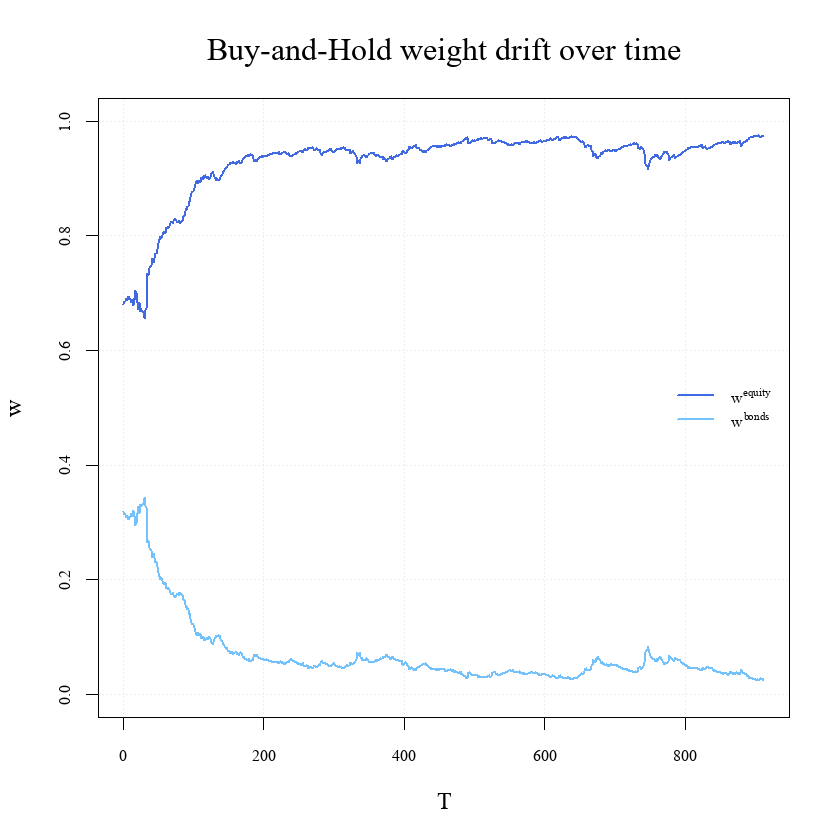

In [30]:
##
#  4.2 Using historical returns to compute the rebalancing premium.
#  Compares rebalancing vs buy-and-hold, and decomposes the premium.
##

# Historical excess returns (equity and bonds)
dataRet    <- as.matrix(dataExcess[, c("equity", "bonds")])
nPeriods   <- nrow(dataRet)

# Optimal CRRA long-horizon weights from Question 4.1
wCrra      <- as.numeric(wCrraLogT)
wBnh       <- matrix(NA, nrow = nPeriods, ncol = 2)
wBnh[1, ]  <- wCrra                      # Buy-and-hold starts at same weights

##
#  Rebalancing strategy returns
##
retRebal   <- dataRet %*% wCrra
amRebal    <- mean(retRebal)
gmRebal    <- exp(mean(log(1 + retRebal))) - 1
volRebal   <- sd(retRebal)

##
#  Buy-and-hold strategy returns
##
retBnH <- matrix(0, nrow = nPeriods, ncol = 1)

for (t in 1:nPeriods){

    # Return in period t
    retBnH[t] <- dataRet[t, ] %*% wBnh[t, ]

    # Update weights (drift)
    if (t < nPeriods){
        wBnh[t + 1, ] <- (1 + dataRet[t, ]) * wBnh[t, ]
        wBnh[t + 1, ] <- wBnh[t + 1, ] / sum(wBnh[t + 1, ])
    }
}

amBnH    <- mean(retBnH)
gmBnH    <- exp(mean(log(1 + retBnH))) - 1
volBnH   <- sd(retBnH)

##
#  Summary statistics for rebalancing and buy-and-hold
##
stats <- matrix(0, nrow = 6, ncol = 2)
colnames(stats) <- c("Rebalanced", "Buy-and-hold")
rownames(stats) <- c("Arithmetic mean", "Geometric mean", "Return volatility",
                     "Mean equity weight", "Equity timing", "Bond timing")

stats[1, ] <- c(amRebal, amBnH) * 100
stats[2, ] <- c(gmRebal, gmBnH) * 100
stats[3, ] <- c(volRebal, volBnH) * 100
stats[4, ] <- c(wCrra[1], mean(wBnh[, 1]))
stats[5, ] <- c(0, cov(wBnh[, 1], dataRet[, 1]) * 100)
stats[6, ] <- c(0, cov(wBnh[, 2], dataRet[, 2]) * 100)

paste("-----------------------------------------------------------------------------------------------")
paste("Summary Statistics for Rebalancing vs Buy-and-Hold (historical data) (%)")
round(stats, 4)

##
#  Rebalancing premium decomposition
##
rebPrem <- matrix(0, nrow = 6, ncol = 1)
colnames(rebPrem) <- c("Decomposition")
rownames(rebPrem) <- c("Rebalancing premium", "Volatility drag",
                       "Mean weights", "Equity timing", "Bond timing", "Total")

#  Rebalancing premium (difference in geometric means)
rebPrem[1] <- (gmRebal - gmBnH) * 100

# Volatility drag
rebPrem[2] <- 0.5 * (volBnH^2 - volRebal^2) * 100

# Mean weight effect
rebPrem[3] <- (wCrra[1] - mean(wBnh[,1])) * mean(dataRet[,1]) * 100 +
              (wCrra[2] - mean(wBnh[,2])) * mean(dataRet[,2]) * 100

# Timing components
rebPrem[4] <- -stats[5, 2]
rebPrem[5] <- -stats[6, 2]

# Total decomposition
rebPrem[6] <- sum(rebPrem[2:5])

paste("-----------------------------------------------------------------------------------------------")
paste("Decomposition of the Rebalancing Premium (%)")
round(rebPrem, 4)
paste("-----------------------------------------------------------------------------------------------")

##
#  Plot Buy-and-Hold weight drift over time
##
par(mfrow=c(1,1), family="Times New Roman")
plot(wBnh[,1], type="l", lwd=2, col="royalblue", ylim=c(0,1),
     main="Buy-and-Hold weight drift over time",
     xlab=TeX("$T$"), ylab=TeX("$w$"),
     cex.main=2,
     cex.lab = 1.5,)
lines(wBnh[,2], lwd=2, col="#73C2FB")
legend("right", legend=c(TeX("$w^{equity}$"),TeX("$w^{bonds}$")),
       col=c("royalblue","#73C2FB"), lwd=2, bty = "n")
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

##
#  Two-component rebalancing premium decomposition
##

# Rebalancing premium (difference in geometric means)
rebPrem <- (gmRebal - gmBnH)

# Volatility drag component
volatilityDrag <- 0.5 * (volBnH^2 - volRebal^2)

# Diversification return (residual)
diversificationReturn <- rebPrem - volatilityDrag

# Output table
decomp2 <- matrix(0, nrow = 3, ncol = 1)
colnames(decomp2) <- "Two-component decomposition"
rownames(decomp2) <- c("Rebalancing premium",
                       "Volatility drag",
                       "Diversification return (RP - VD)")

decomp2[1] <- rebPrem * 100
decomp2[2] <- volatilityDrag * 100
decomp2[3] <- diversificationReturn * 100

paste("Rebalancing premium in two component decomposition (Volatility Drag + Diversification Return) (%)")
round(decomp2, 4)
paste("-----------------------------------------------------------------------------------------------")

In [31]:
##
#  4.3 A) Run regressions on equity and bonds
##

# Total observations
T <- nrow(data)

# Predictors at time t (drop last row)
usPriceToDividend <- data$`P/D`[1:(T-1)]
usCape            <- data$`P/E`[1:(T-1)]
us10Yyield        <- data$y_10y[1:(T-1)]

# Returns at time t+1 (drop first row)
usEqReturn        <- data$us_eq[2:T]
us10YBondReturn   <- data$us_t10yr[2:T]
inflationLagged   <- data$us_infl[2:T] 
rRfLagged         <- data$us_t1m[2:T]
rRealRfLagged     <- (1 + rRfLagged)/(1 + inflationLagged) - 1

# Compute excess return adjusted to inflation
equity <- ((1 + usEqReturn)      / (1 + inflationLagged) - 1) - rRealRfLagged
bonds  <- ((1 + us10YBondReturn) / (1 + inflationLagged) - 1) - rRealRfLagged

# Perform regressions
regrEquityOnPd         <- summary(lm(equity ~ usPriceToDividend))
regrEquityOnCape       <- summary(lm(equity ~ usCape))
regrEquityOnPdPlusCape <- summary(lm(equity ~ usPriceToDividend + usCape))
regrBondsOn10Yyield    <- summary(lm(bonds  ~ us10Yyield))

# Print results
paste("Regression -> equity ~ PD")
round(regrEquityOnPd$coefficients, 4)
paste("-----------------------------------------------------------------------------------------------")
paste("Regression -> equity ~ CAPE")
round(regrEquityOnCape$coefficients, 4)
paste("-----------------------------------------------------------------------------------------------")
paste("Regression -> equity ~ PD + CAPE")
round(regrEquityOnPdPlusCape$coefficients, 4)
paste("-----------------------------------------------------------------------------------------------")
paste("Regression -> bonds ~ 10YBondReturn")
round(regrBondsOn10Yyield$coefficients, 4)

[1] "Regression -> equity ~ PD"

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.0133,0.0036,3.7386,0.0002
usPriceToDividend,-0.0002,0.0001,-2.1247,0.0339


[1] "-----------------------------------------------------------------------------------------------"

[1] "Regression -> equity ~ CAPE"

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.0119,0.0038,3.1646,0.0016
usCape,-0.0003,0.0002,-1.5926,0.1116


[1] "-----------------------------------------------------------------------------------------------"

[1] "Regression -> equity ~ PD + CAPE"

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.0120,0.0038,3.1844,0.0015
usPriceToDividend,-0.0004,0.0002,-1.7555,0.0795
usCape,0.0005,0.0005,1.0533,0.2925


[1] "-----------------------------------------------------------------------------------------------"

[1] "Regression -> bonds ~ 10YBondReturn"

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-0.0011,0.0014,-0.8313,0.4060
us10Yyield,0.0449,0.0226,1.9851,0.0474
